
## Chapter 3 [Imaging](Ch3-Imaging.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Find Atom Positions with Blob Detector


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes







## First we import the usual libraries
Please visit the  section for [pyTEMlib](Ch1-Prerequisites.ipynb#TEM_Library) of the [Prerequesites](Ch1-Prerequisites.ipynb) section for information of necessary packages.

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt

# Import libraries from the book

import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.image_tools as it

# import packages for pyUSID
import pyUSID as usid
import h5py

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyUSID version: ',usid.__version__)
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'CH3-Find_Atoms'
__notebook_version__ = '2019_04_20'


Populating the interactive namespace from numpy and matplotlib
windows
pyUSID version:  0.0.4
pyTEM version:  0.6.2019.2


## Load an image :
If it is a image stack please do the [Image Registration](CH3-Image_Registration.ipynb) notebook first.

We load an image and we start our calculation log, which we set up as a python dictionary. <br>
Please note that the **open file dialog** might not apear in the foreground!



Log_000 includes analysis: Rigid Registration
Log_001 includes analysis: Non-Rigid Registration


<IPython.core.display.Javascript object>


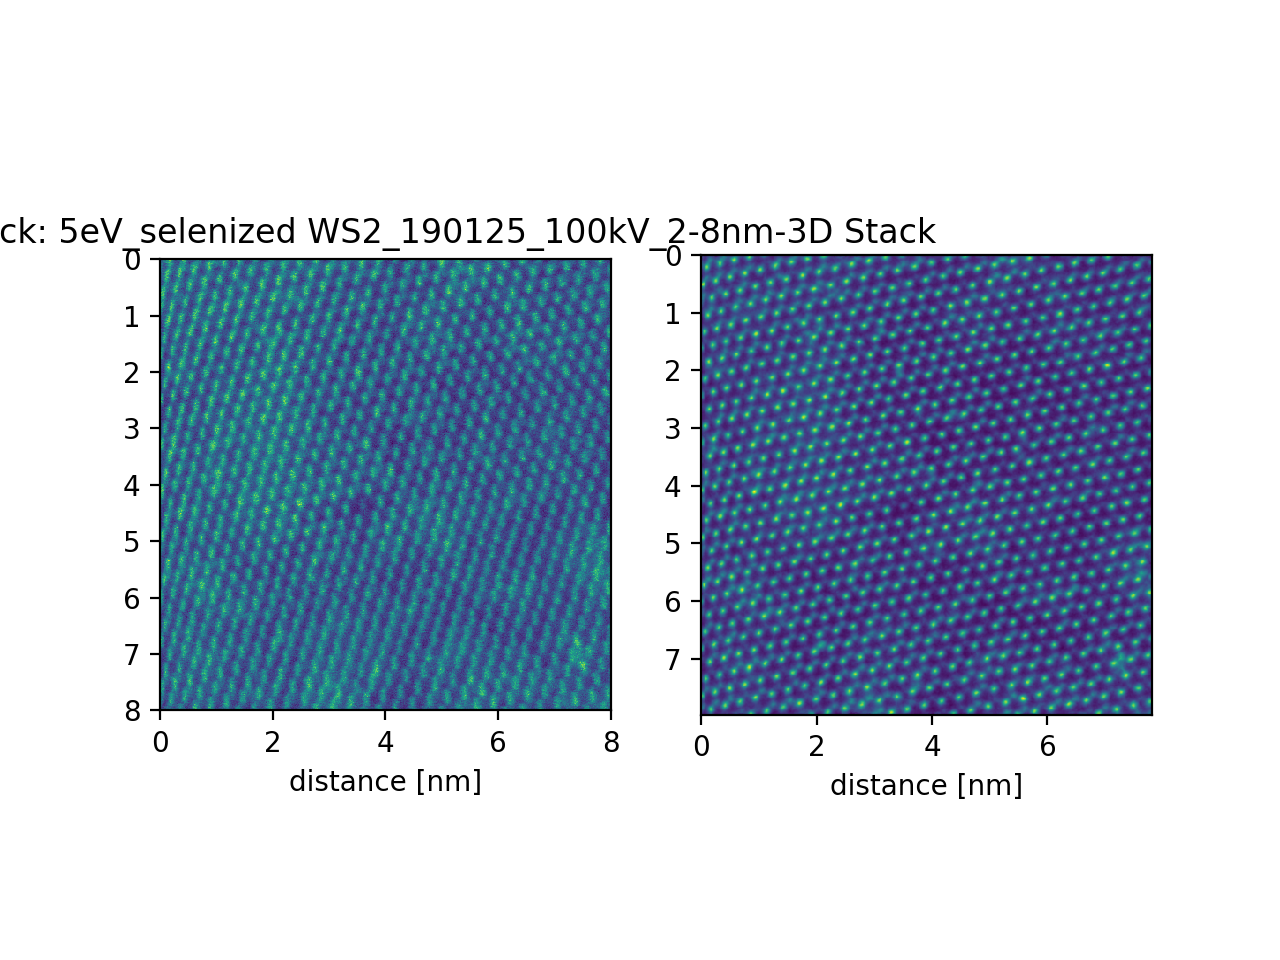

In [2]:
# Load file
#h5_file.close()
h5_file = ft.h5open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']

log_channel = current_channel
for key in current_channel:
    if 'Log' in key:
        print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")
        if 'Registration' in current_channel[key]['analysis'][()]:
            log_channel = current_channel[key]


if log_channel == current_channel:
    ft.plt_pyUSID(current_channel)   
    data = log_channel['Raw_Data'][()]
else:
    fig, [ax1,ax2] = plt.subplots(1,2)
    ft.plt_pyUSID(current_channel, ax1)
    ax2.imshow(log_channel['data'][()],origin='upper', extent = log_channel['extent'][()])
    ax2.set_xlabel('distance ['+ log_channel['spatial_units'][()]+']');
    
    data = log_channel['data'][()]


out_tags = {}


# Blob Detection

We use the blob detector of skimage package of scipy to find the atoms.

In [3]:
def find_atoms(im, tags, verbose = False):
    from skimage.feature import  blob_log #blob_dog, blob_doh
    if 'rel_blob_size' not in tags:
        tags['rel_blob_size'] = .4 # between 0 and 1 nromally around 0.5
        tags['source_size'] = 0.06 #in nm gives the size of the atoms or resolution
        tags['nearest_neighbours'] = 7 # up to this number nearest neighbours are evaluated (normally 7)
        tags['threshold'] =  .15 # between 0.01 and 0.1 
        tags['rim_size'] = 2# size of rim in multiples of source size
        
    rel_blob_size = tags['rel_blob_size'] # between 0 and 1 nromally around 0.5
    source_size = tags['source_size']  #in nm gives the size of the atoms
    nearest_neighbours  = tags['nearest_neighbours'] # up to this number nearest neighbours are evaluated (normally 7)
    threshold = tags['threshold']  # between 0.01 and 0.1 
    rim_size = tags['rim_size'] # sizeof rim in multiples of resolution
    pixel_size = tags['pixel_size']
                      
    rim_width = rim_size*source_size/pixel_size
    
    ## Get a noise free image: reduced
    #pixel_size = FOV/im.shape[0]
    reduced_image = it.clean_svd(im,pixel_size=pixel_size,source_size=source_size)

    reduced_image = reduced_image-reduced_image.min()
    reduced_image = reduced_image/reduced_image.max()
    out_tags = {}
    out_tags['reduced_image'] = reduced_image
    patch_size = im.shape[0]-reduced_image.shape[0]
    out_tags['patch_size'] = patch_size
    print(f' Use {patch_size} x {patch_size} pixels for image-patch of atoms')

    # Find atoms    
    thresh = reduced_image.std()*threshold
    blobs = blob_log(np.array(reduced_image), max_sigma=source_size/pixel_size, threshold=thresh)
    plot_image = im[int(patch_size/2):,int(patch_size/2):]

    atoms = []
    from skimage.feature import blob_log
    for blob in blobs:
        y, x, r = blob
        if r > patch_size*rel_blob_size:
            atoms.append([x+patch_size/2,y+patch_size/2,r])

    rim_atoms = []

    for i in range(len(atoms)):
        if (np.array(atoms[i][0:2])<rim_width).any() or (np.array(atoms[i]) > im.shape[0]-rim_width-5).any():
            rim_atoms.append(i)
    rim_atoms=np.unique(rim_atoms)
    mid_atoms_list = np.setdiff1d(np.arange(len(atoms)),rim_atoms)
    
    mid_atoms = np.array(atoms)[mid_atoms_list]
    if verbose:
        print(f'Evaluated {len(mid_atoms)} atom positions, out of {len(atoms)} atoms')
    
    
    out_tags['atoms'] = atoms
    out_tags['mid_atoms'] = mid_atoms
    out_tags['rim_atoms'] = rim_atoms
    out_tags['number_of_atoms'] = len(atoms)
    out_tags['number_of_evaluated_atoms' ]= len(mid_atoms)
    print(f'Evaluated {len(mid_atoms)} atom positions')
    
    return out_tags

The input ...

The source size 100.0 pm is used as measure of atom size which is a patch with diameter 6 pixels  
6
 Use 5 x 5 pixels for image-patch of atoms
Evaluated 1133 atom positions
dict_keys(['reduced_image', 'patch_size', 'atoms', 'mid_atoms', 'rim_atoms', 'number_of_atoms', 'number_of_evaluated_atoms'])


<IPython.core.display.Javascript object>


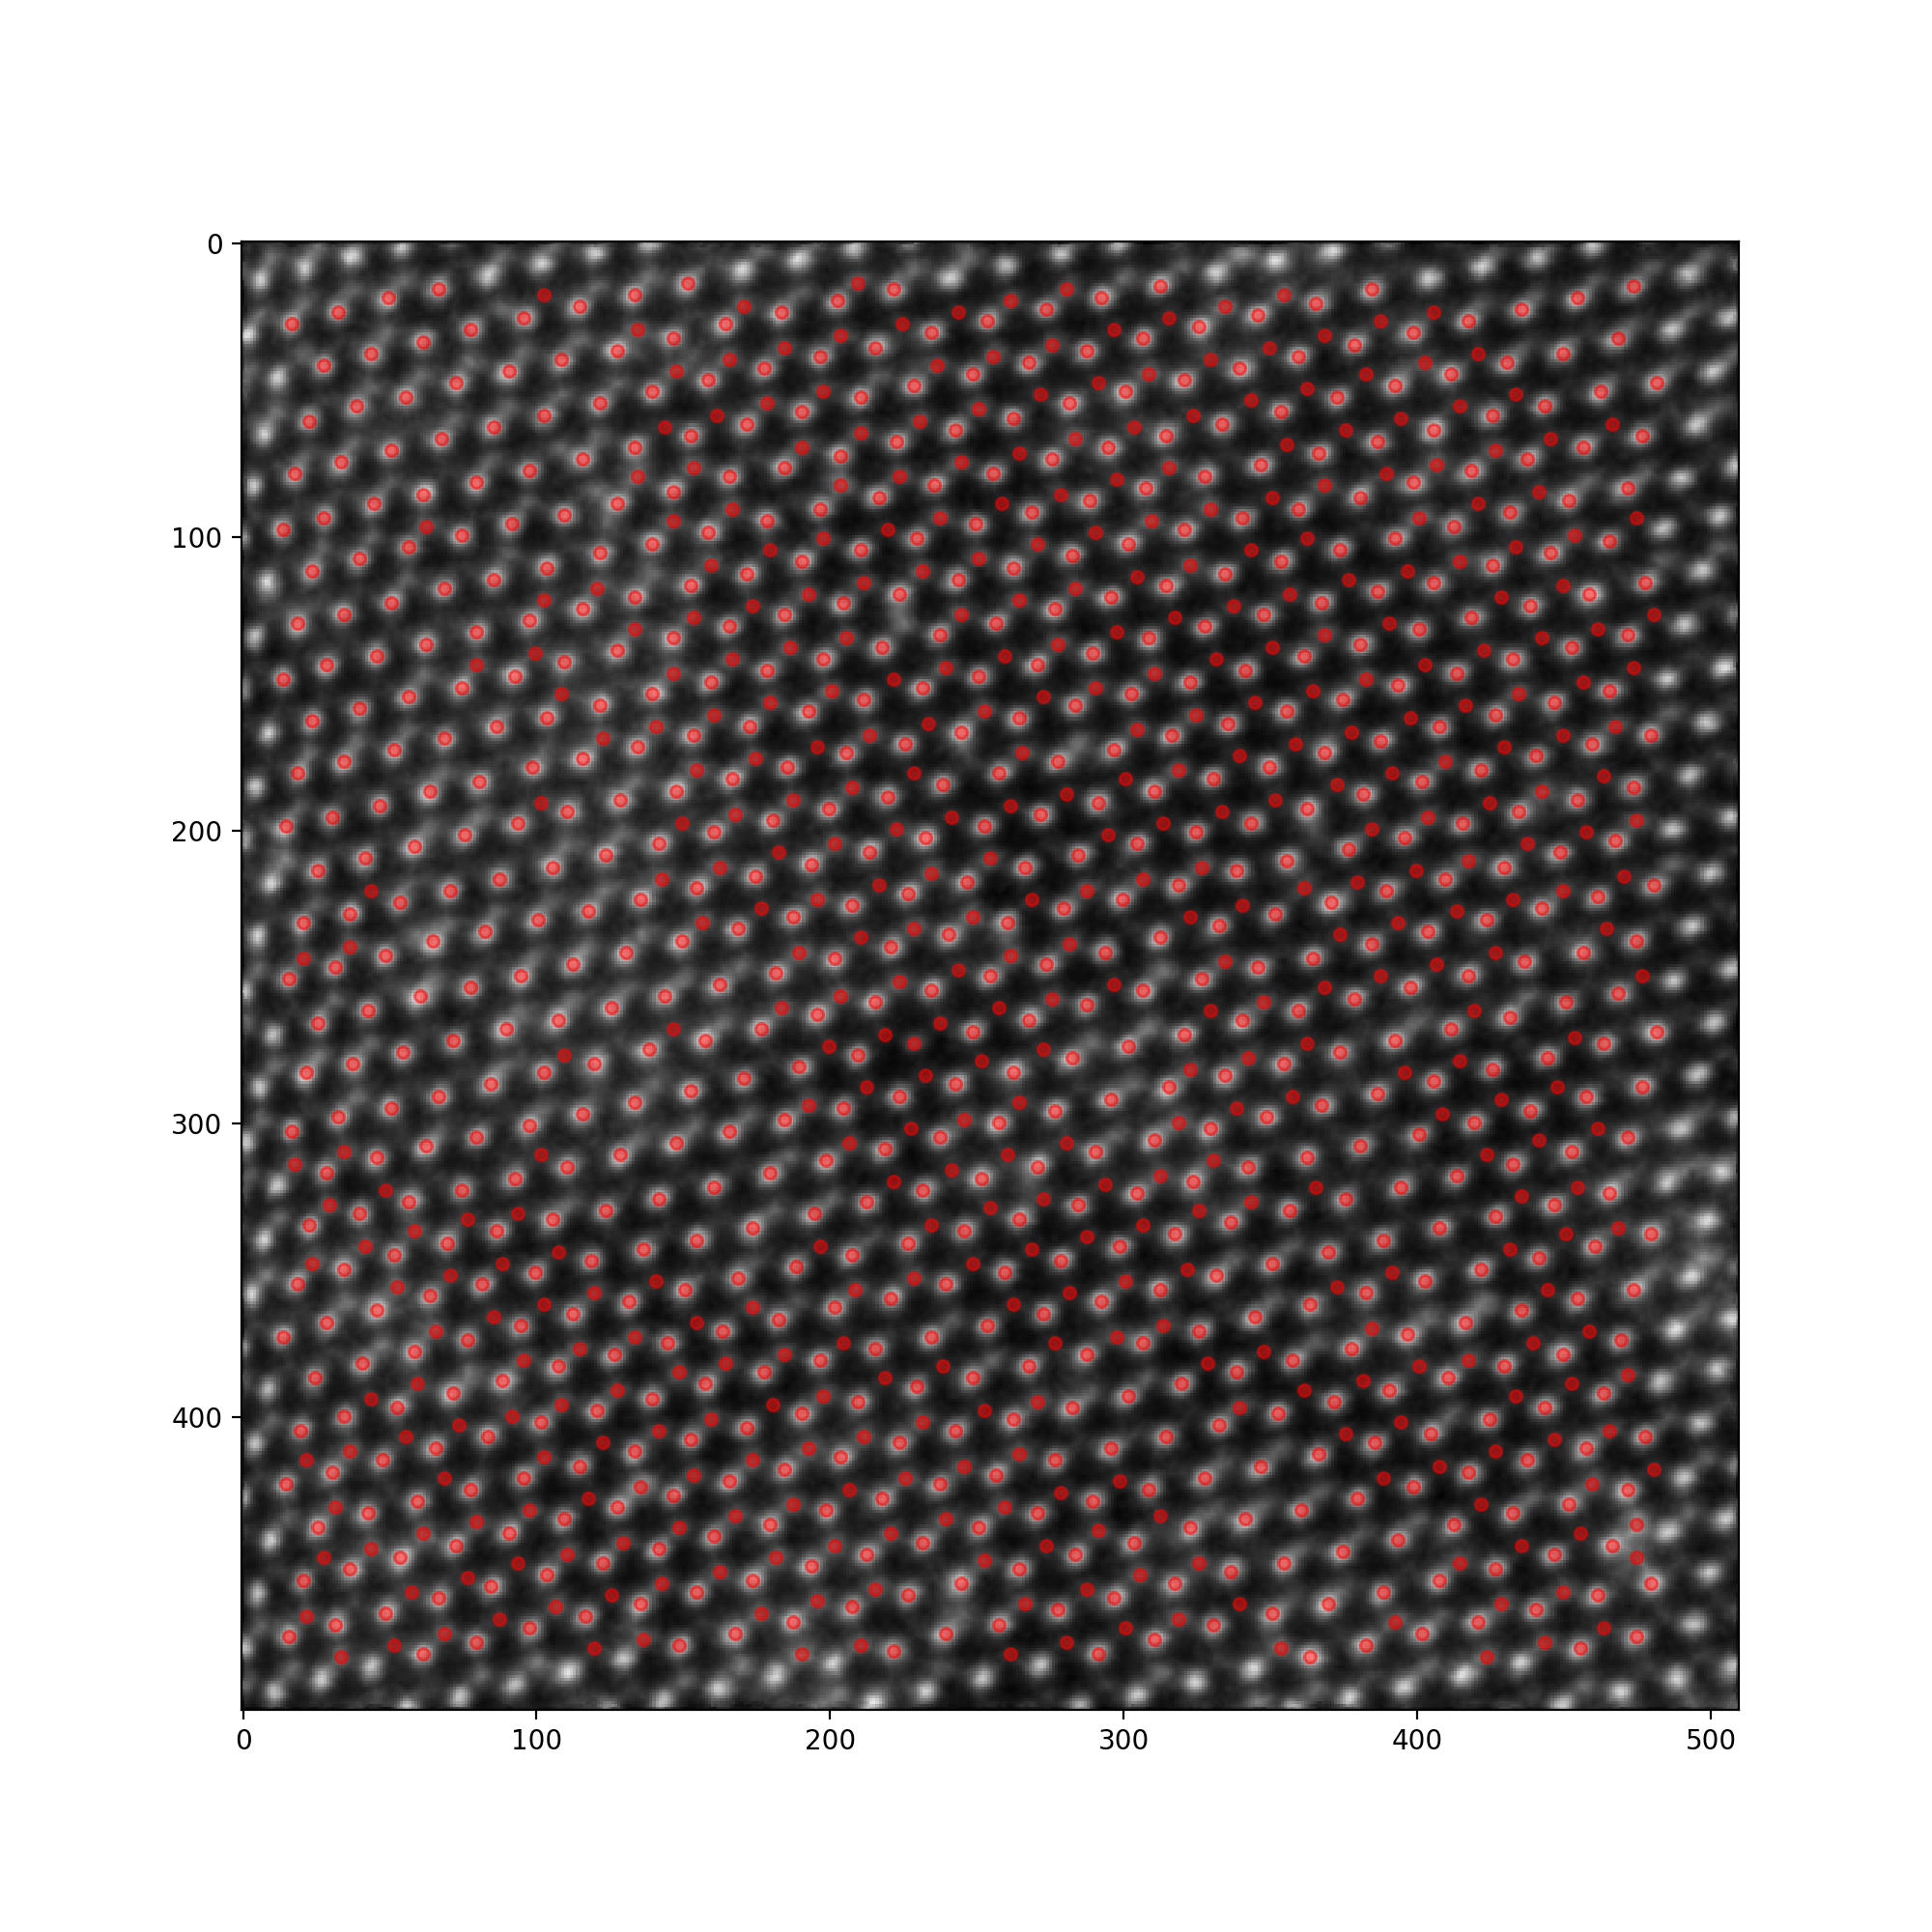

In [6]:

image_size = min(data.shape)
#########
# INPUT #
#########
out_tags  =  {}
out_tags['image'] = data
out_tags['rel_blob_size'] = .1 # between 0 and 1 nromally around 0.5
out_tags['source_size'] = 0.1 #in nm gives the size of the atoms or resolution
out_tags['nearest_neighbours'] = 7 # up to this number nearest neighbours are evaluated (normally 7)
out_tags['threshold'] =  .02 # between 0.01 and 0.1 
out_tags['rim_size'] = 2# size of rim in multiples of source size
out_tags['spatial_scale_x'] = current_channel['spatial_scale_x'][()]
out_tags['spatial_scale_y'] = current_channel['spatial_scale_y'][()]
out_tags['pixel_size'] = current_channel['spatial_scale_x'][()]

print(f"The source size {out_tags['source_size']*1000:.1f} pm is used as measure of atom size which is a patch with diameter {out_tags['source_size']/ out_tags['pixel_size']:.0f} pixels  " )


tags  = find_atoms(data[0:image_size,0:image_size], out_tags)
print(tags.keys())
out_tags.update(tags)

#fig1, ax = plt.subplots(1, 2,figsize=(10,10))
#ax[0].set_title("blobs")
plt.figure(figsize=(10,10))
plt.imshow(data, interpolation='nearest',cmap='gray')
plt.scatter(out_tags['mid_atoms'][:, 0], out_tags['mid_atoms'][:, 1], c='r', s=20, alpha = .5);

## Log Atom Positions

In [8]:
out_tags['analysis']= 'Atom Positions'
out_tags['notebook']= __notebook__ 
out_tags['notebook_version']= __notebook_version__


out_tags['data'] = data
out_tags['log_channel'] = log_channel.name.split('/')[-1]
out_tags['spatial_origin_x'] = 0.
out_tags['spatial_origin_y'] = 0.
out_tags['spatial_scale_x'] = current_channel['spatial_scale_x'][()]
out_tags['spatial_scale_y'] = current_channel['spatial_scale_y'][()]
out_tags['spatial_size_x'] = data.shape[0]
out_tags['spatial_size_y'] = data.shape[1]
out_tags['spatial_units'] = 'nm'


FOV_x = out_tags['spatial_size_x']* out_tags['spatial_scale_x']
FOV_y = out_tags['spatial_size_y']* out_tags['spatial_scale_y']
out_tags['extent'] = [0,FOV_x,FOV_y, 0]
name = 'Atom finding'
        
log_group = ft.h5_add_Log(current_channel, name)
ft.h5_add_Data2Log(log_group, out_tags)

for key in current_channel:
    if 'Log' in key:
        print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")
        
        log_channel = current_channel[key]

Log_000 includes analysis: Rigid Registration
Log_001 includes analysis: Non-Rigid Registration
Log_002 includes analysis: Atom Positions


# Why and How to Refine Atom Positions

source size is 70 pm
2 [ 3.72388068 -0.10693597 -0.45792529  1.67656317]
Old Atom Position 71, 427
New Atom Position 70.89, 426.54


<IPython.core.display.Javascript object>


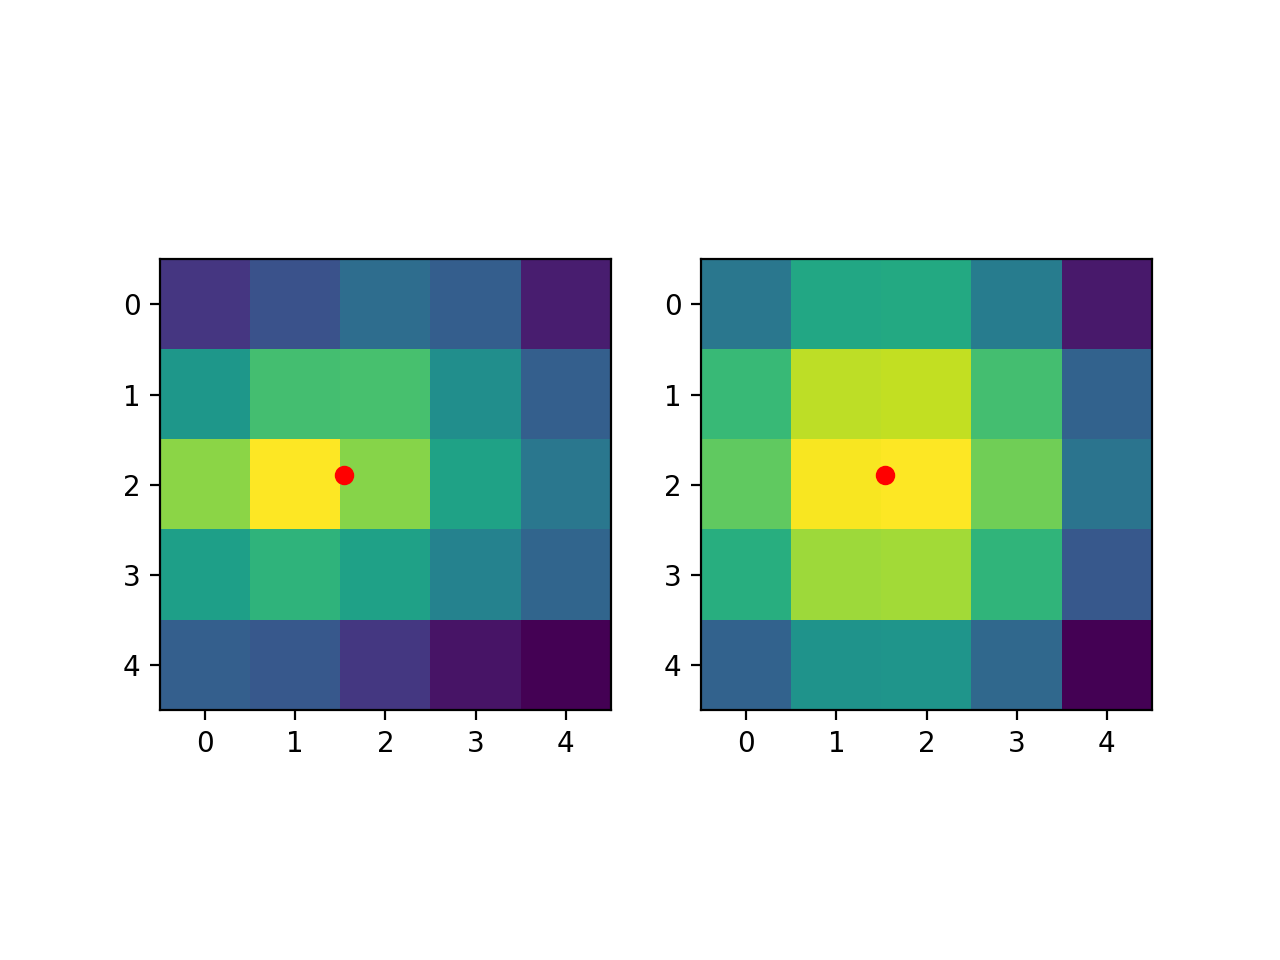

146.0801821975873
36.170208 36.16659882941709


<IPython.core.display.Javascript object>


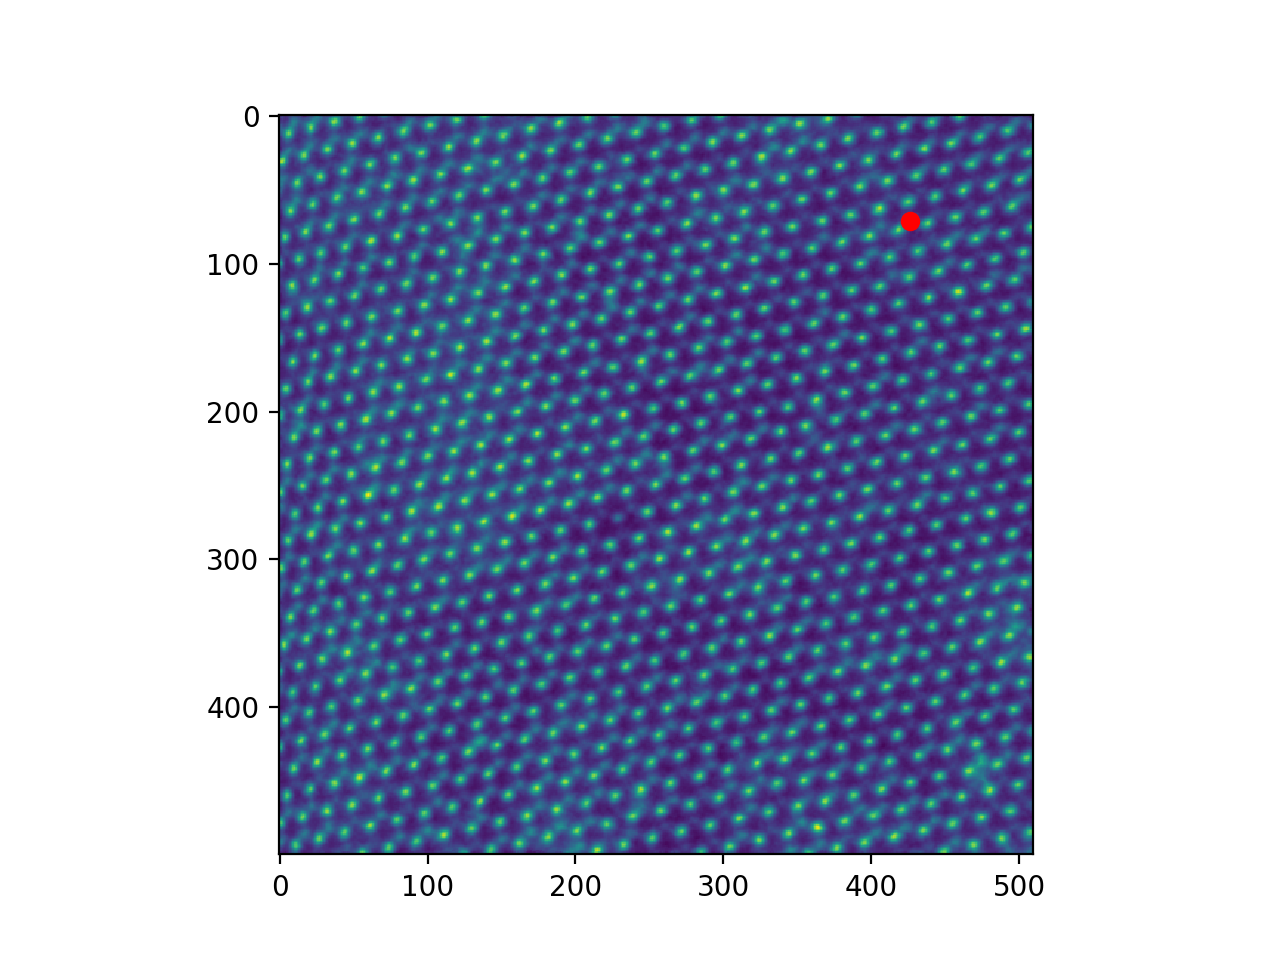

426.5420747147102 70.893064025457


In [9]:
#########
# Input # select which atom to fit and how big of an area we use.
#########

which_atom = i = 997 #select a random atom


## Area of atom is determined by the source_size parameter which is supposed to give us the radius of the atom blob
## If source size is too large, then there are more than one atom in the area to be fitted and stupid things will occur.
log_channel=current_channel['Log_002']
source_size = 0.1 
source_size = log_channel['source_size'][()]*.7
print(f'source size is {source_size*1000:.0f} pm')



## Let's amke a round mask 
radius = int((source_size/ log_channel['spatial_scale_x'][()]/2.+0.5))
pixels = np.linspace(0,2*radius,2*radius+1)-radius
x_mask,y_mask = np.meshgrid(pixels,pixels);
mask = (x_mask**2+y_mask**2) < radius**2 #


## area which contains the atom
atoms = log_channel['mid_atoms'][()]

y,x = atoms[which_atom][0:2]
x = int(x+0.5)
y = int(y+0.5)

area = data[x-radius:x+radius+1,y-radius:y+radius+1]#*mask


from scipy.optimize import leastsq

def Gauss_2D(params, ydata):
    width = int(ydata.shape[0]/2)
    Gauss_width = params[0]
    x0 = params[1]
    y0 = params[2]
    inten = params[3]

    x, y = np.mgrid[-width:width+1, -width:width+1]


    return np.exp(-((x-x0)**2 + (y-y0)**2) /2./ Gauss_width**2)*inten
def Gauss_difference (params,  xdata, ydata):
    #self.img1b.setImage(gauss)
    gauss = Gauss_2D(params, ydata)
    return (ydata - gauss).flatten()

guess  = [radius*2, 0.0, 0.0 , 1]    
pout, res =  leastsq(Gauss_difference, guess, args=(area, area))
print(radius, pout)
new_x = x+pout[1]
new_y = y+pout[2]

print(f'Old Atom Position {x}, {y}')
print(f'New Atom Position {new_x:.2f}, {new_y:.2f}')

fig, [ax1,ax2] = plt.subplots(1,2)
ax1.imshow(area, origin='upper')


gauss = Gauss_2D(pout,area)
Gauss_width = pout[0]
inten = pout[3]
print(inten*2*np.pi*Gauss_width**2)
width = int(area.shape[0]/2)
ax1.scatter(pout[2]+width,pout[1]+width,color='red')

ax2.scatter(pout[2]+width,pout[1]+width,color='red')
ax2.imshow(gauss, origin='upper')

print(area.sum(),gauss.sum())
plt.figure()
plt.imshow(data, origin='upper')
plt.scatter(pout[2]+y,pout[1]+x,color='red')

print(pout[2]+y,pout[1]+x)

## Refine All Atom Positions

In [10]:
from scipy.optimize import leastsq
def atomRefine(image, atoms, tags, maxDist = 2):
    
    rr = int(tags['radius']+0.5) # atom radius
    print('using radius ',rr, 'pixels')
    
    pixels = np.linspace(0,2*rr,2*rr+1)-rr
    x,y = np.meshgrid(pixels,pixels);
    mask = (x**2+y**2) < rr**2 #
    

    def Gauss_2D(params, ydata):
        width = int(ydata.shape[0]/2)
        Gauss_width = params[0]
        x0 = params[1]
        y0 = params[2]
        inten = params[3]

        x, y = np.mgrid[-width:width+1, -width:width+1]


        return np.exp(-((x-x0)**2 + (y-y0)**2) /2./ Gauss_width**2)*inten
    def Gauss_difference (params,  xdata, ydata):
        #self.img1b.setImage(gauss)
        gauss = Gauss_2D(params, ydata)
        return (ydata - gauss).flatten()

    guess  = [radius*2, 0.0, 0.0 , 1]    
    
    #tags['symmetry'] = {}
    sym = {}
    sym['number_of_atoms'] = len(atoms)
    
    volume = []
    position = []
    intensity_area = []
    maximum_area = []
    newatoms = []
    Gauss_width = []
    Gauss_amplitude = []
    Gauss_intensity = []
    
    for i in range(len( atoms)):
        
        y,x = atoms[i][0:2]
        x = int(x)
        y = int(y)
        append = False
        
        
        area = image[x-rr:x+rr+1,y-rr:y+rr+1]
       
        append = False
        
        if (x-rr) < 0 or y-rr <0 or x+rr+1 > image.shape[0] or y+rr+1 > image.shape[1]:
            position.append(-1)
            intensity_area.append(0) 
            maximum_area.append(0)
        else:
            position.append(1)
            intensity_area.append((area*mask).sum() )
            maximum_area.append((area*mask).max())
            
        if tags['MaxInt']>0:
            if area.sum()< tags['MaxInt']:                    
                if area.sum() > tags['MinInt']:
                    append = True
        elif area.sum()> tags['MinInt']:
            append = True
        
        pout = [0,0,0,0]
        if append:
            if (x-rr) < 0 or y-rr <0 or x+rr+1 > image.shape[0] or y+rr+1 > image.shape[1]:
                pass
            else:
                pout, res =  leastsq(Gauss_difference, guess, args=(area, area))
                
            if (abs(pout[1])> maxDist) or (abs(pout[2])> maxDist):
                pout = [0,0,0,0]
    
        volume.append(2* np.pi * pout[3] * pout[0]*pout[0])

        newatoms.append([y+pout[2], x+pout[1]])# ,pout[0],  volume)) #,pout[3]))
        if (all(v == 0 for v in pout)):
            Gauss_intensity.append(0.)
        else:
            Gauss_intensity.append((Gauss_2D(pout, area)*mask).sum() )
        Gauss_width.append(pout[0])
        Gauss_amplitude.append(pout[3])
    
    
    sym['inside'] = position
    sym['intensity_area'] = intensity_area 
    sym['maximum_area'] = maximum_area
    sym['atoms'] = newatoms
    sym['Gauss_width'] = Gauss_width
    sym['Gauss_amplitude'] = Gauss_amplitude
    sym['Gauss_intensity'] = Gauss_intensity
    sym['Gauss_volume'] = volume
    
    return sym

using radius  3 pixels


C:\Users\gduscher\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


dict_keys(['number_of_atoms', 'inside', 'intensity_area', 'maximum_area', 'atoms', 'Gauss_width', 'Gauss_amplitude', 'Gauss_intensity', 'Gauss_volume'])


<IPython.core.display.Javascript object>


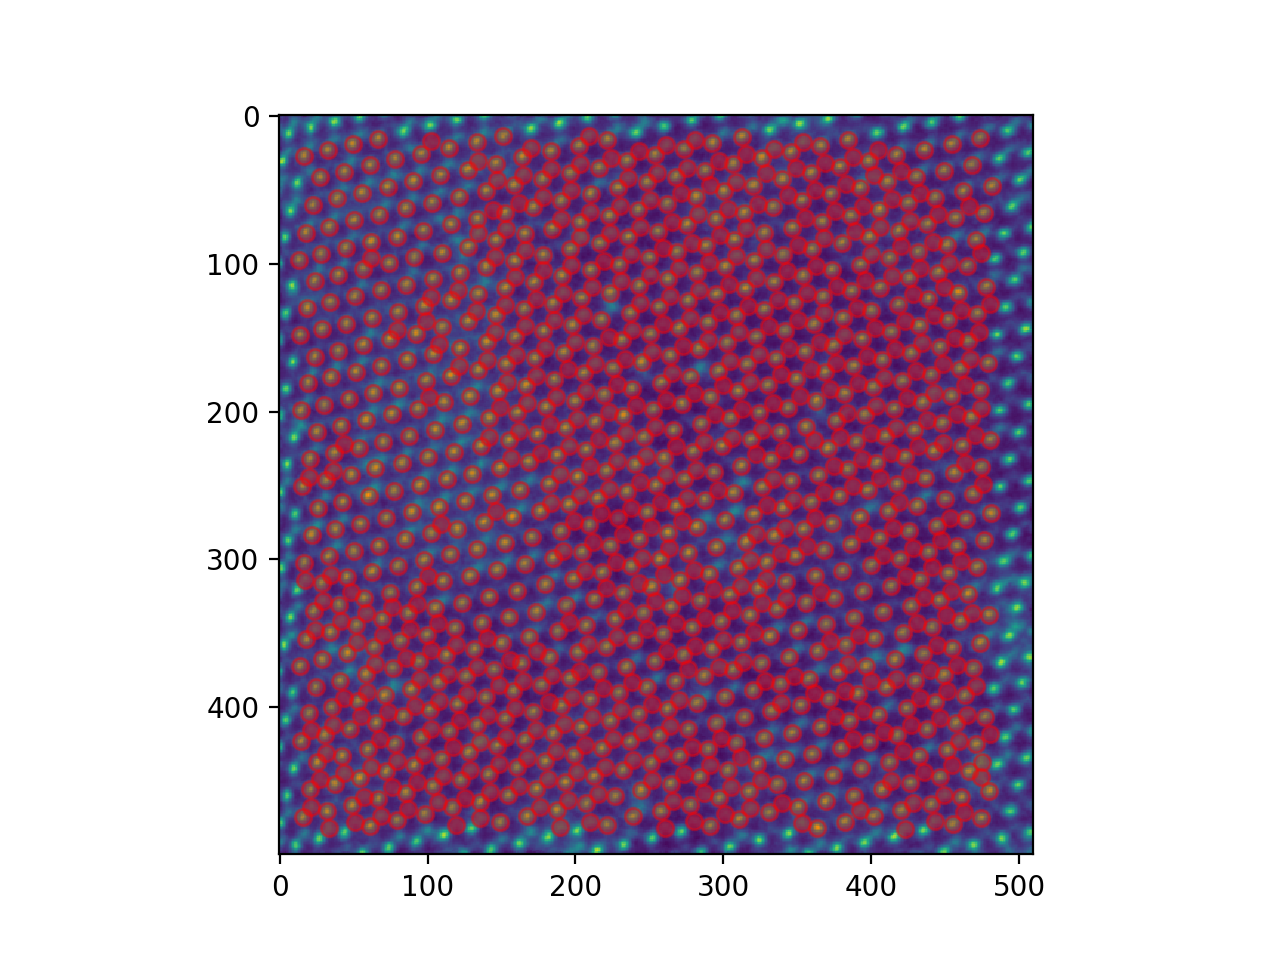

In [11]:

out_tags['radius'] = log_channel['source_size'][()] / log_channel['spatial_scale_x'][()]/2# out_tags['atoms']['source_size']
out_tags['MaxInt'] = 0
out_tags['MinInt'] = 0

sym = atomRefine(data,log_channel['mid_atoms'][()], out_tags)

print(sym.keys())
out_tags2 = {}
out_tags2['radius'] = out_tags['radius']
out_tags2['MaxInt'] = out_tags['MaxInt']
out_tags2['MinInt'] = out_tags['MinInt']

out_tags2.update(sym)

plt.figure()
plt.imshow(data, origin='upper')
plt.scatter(np.array(out_tags2['atoms'])[:,0],np.array(out_tags2['atoms'])[:,1],color='red',alpha=0.4);


## Intensity Histogram

Here we compare two intensity values, the simple sum of the area of the atom (with a round mask) and the amplitude of the Gaussian that we fitted in to the atom blob.


3.5900097006961347
[38.62545653 73.84234265 39.68263902 ... 66.5015388  37.34533427
 64.64934764]
[ 0.          0.75244308  1.50488616  2.25732924  3.00977232  3.7622154
  4.51465848  5.26710156  6.01954464  6.77198771  7.52443079  8.27687387
  9.02931695  9.78176003 10.53420311 11.28664619 12.03908927 12.79153235
 13.54397543 14.29641851 15.04886159 15.80130467 16.55374775 17.30619083
 18.05863391 18.81107699 19.56352007 20.31596314 21.06840622 21.8208493
 22.57329238 23.32573546 24.07817854 24.83062162 25.5830647  26.33550778
 27.08795086 27.84039394 28.59283702 29.3452801  30.09772318 30.85016626
 31.60260934 32.35505242 33.10749549 33.85993857 34.61238165 35.36482473
 36.11726781 36.86971089 37.62215397 38.37459705 39.12704013 39.87948321
 40.63192629 41.38436937 42.13681245 42.88925553 43.64169861 44.39414169
 45.14658477 45.89902785 46.65147092 47.403914   48.15635708 48.90880016
 49.66124324 50.41368632 51.1661294  51.91857248 52.67101556 53.42345864
 54.17590172 54.9283448  55.

<IPython.core.display.Javascript object>


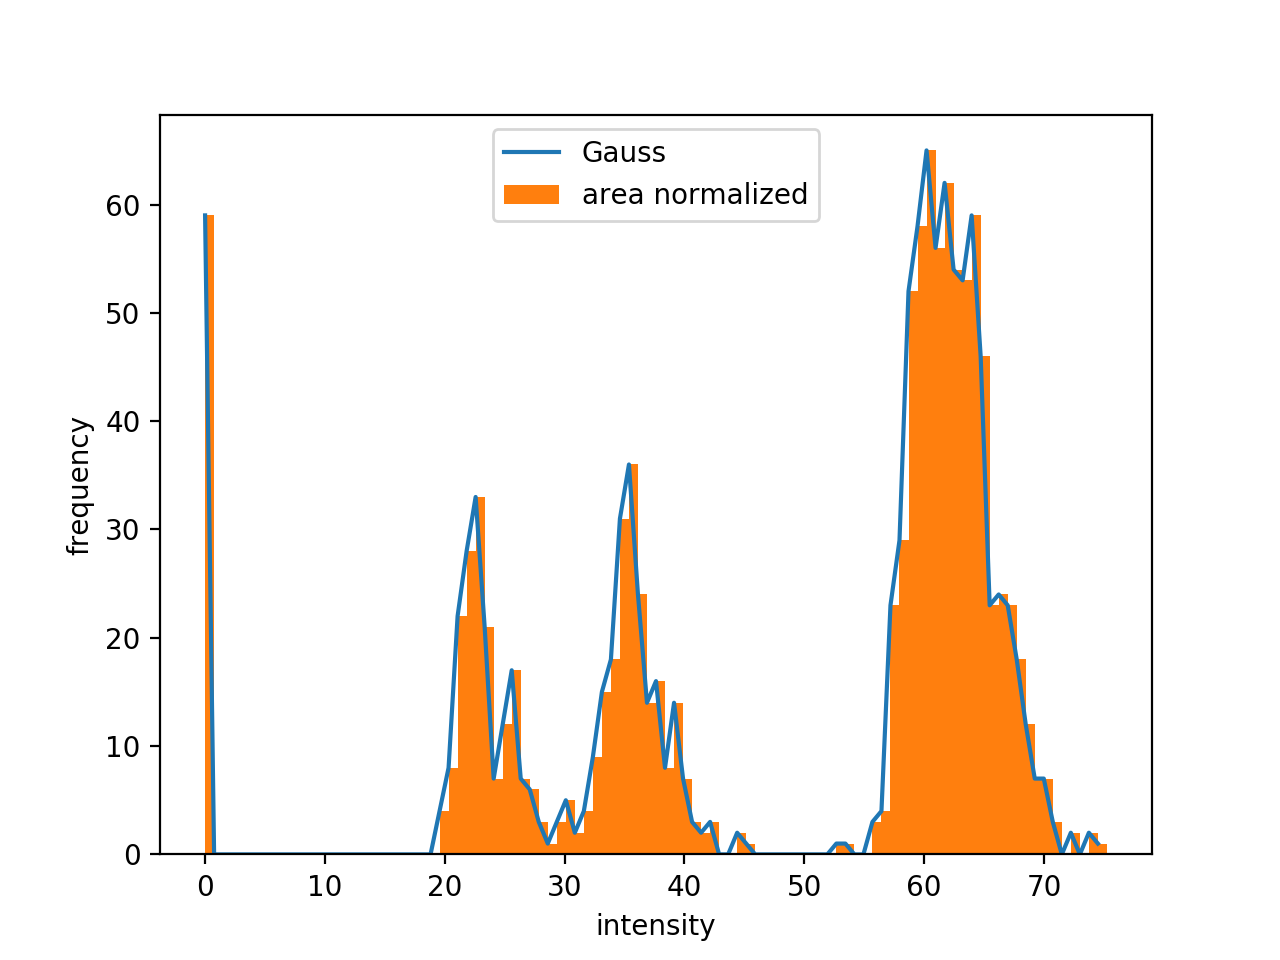

In [12]:
nbins = 100    
print(np.median(out_tags2['Gauss_width']))
Gauss_volume = np.array(out_tags2['Gauss_intensity'])
print(Gauss_volume)
hist_frequency, histo_intensities = np.histogram(Gauss_volume, bins=nbins)
print(histo_intensities)

out_tags2['histogram_intensities'] = histo_intensities
out_tags2['histogram_multiplicity'] = hist_frequency[:-1]
plt.figure()
plt.plot(histo_intensities[:-1],hist_frequency,label='Gauss')
plt.hist(np.array(out_tags2['Gauss_intensity']), bins=nbins, label = 'area normalized');

#plt.hist(np.array(out_tags2['Gauss_amplitude']), bins=nbins, label = 'Gauss');
plt.xlabel('intensity')
plt.ylabel('frequency');
plt.legend();

<IPython.core.display.Javascript object>


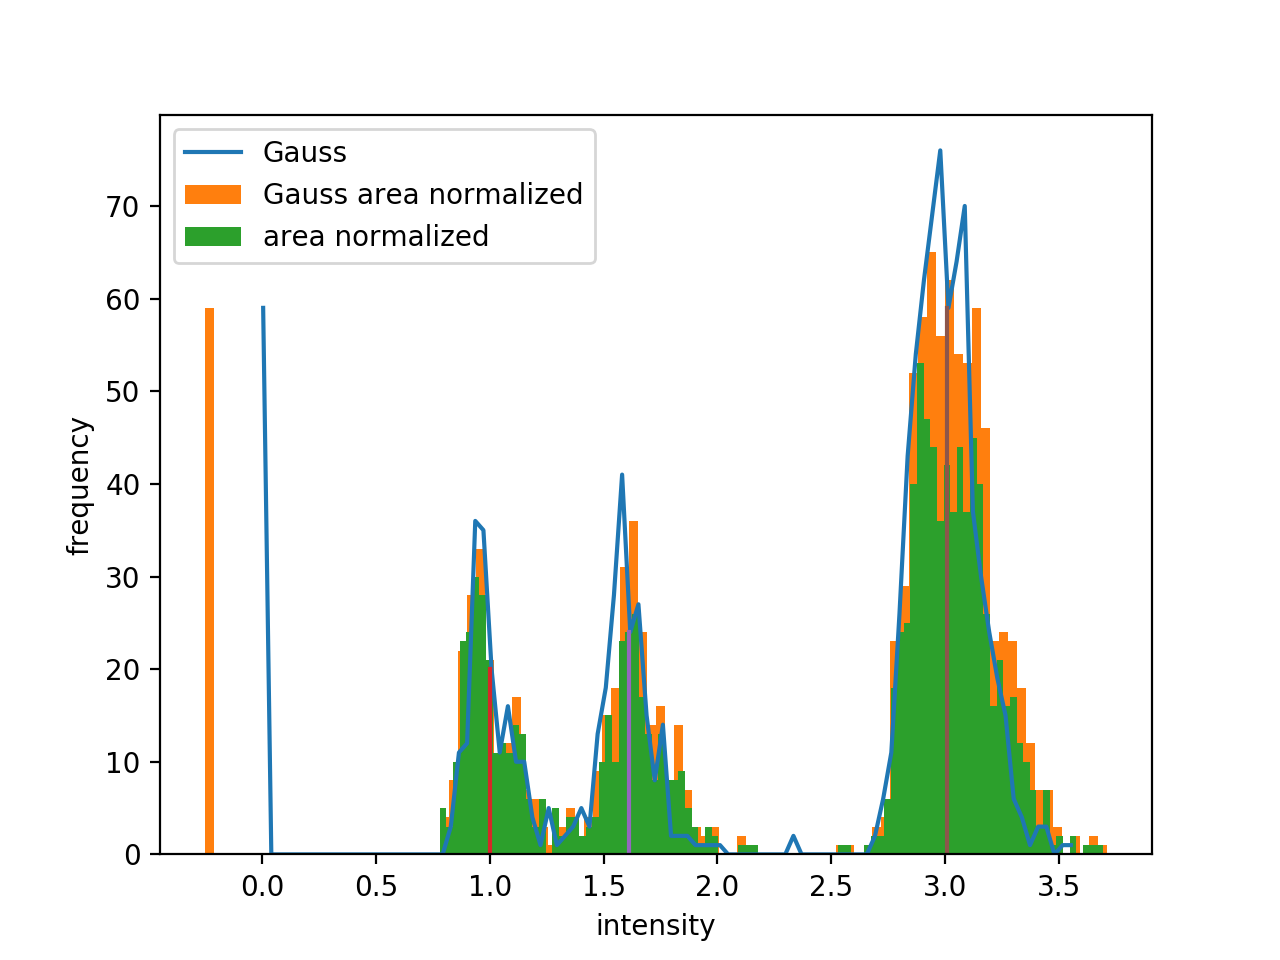

In [13]:
nbins = 100    
histo_frequency, histo_intensities = np.histogram(out_tags2['Gauss_amplitude'], bins=nbins)


out_tags2['histogram_intensities'] = histo_intensities[:-1]
out_tags2['histogram_multiplicity'] = histo_frequency
plt.figure()
plt.plot(histo_intensities[:-1]+0.005,histo_frequency,label='Gauss')
plt.hist(np.array(out_tags2['Gauss_intensity'])/19-.25, bins=nbins, label = 'Gauss area normalized');
plt.hist(np.array(out_tags2['intensity_area'])/19-.25, bins=nbins, label = 'area normalized');

#plt.hist(np.array(out_tags2['Gauss_amplitude']), bins=nbins, label = 'Gauss');
plt.xlabel('intensity')
plt.ylabel('frequency');
plt.legend();

## Fit Histogram

In a Z-contrast image the relative intensity of the atoms is approximatively with the added atomic number **Z** of a monolayer squared. 

here the brightest atom should be tungston (W) with atomic number Z while the other atoms should be two sulfur (2*16) or one sulfur and one selenium atom (16+34 = 2*25).

So first we find the peak positions (with the find_peaks_cwt function in the sipy.signal package) and then we fit Guassians on the histogram.
The peak posiitons give us the relative intensities.

$ I_{relative} = \frac{Z_W^2}{(Z_S+Z_{Se})^2}$
$ I_{relative} = \frac{Z_W^2}{(Z_S+Z_{Se})^2}$


which translate into $ (Z_S+Z_{Se}) = \sqrt{ \frac{Z_W^2}{I_{relative}}}$

peak positions: 0.97, 1.59, 2.98
chalcagenite site average Z: 23.93, 39.36


C:\Users\gduscher\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


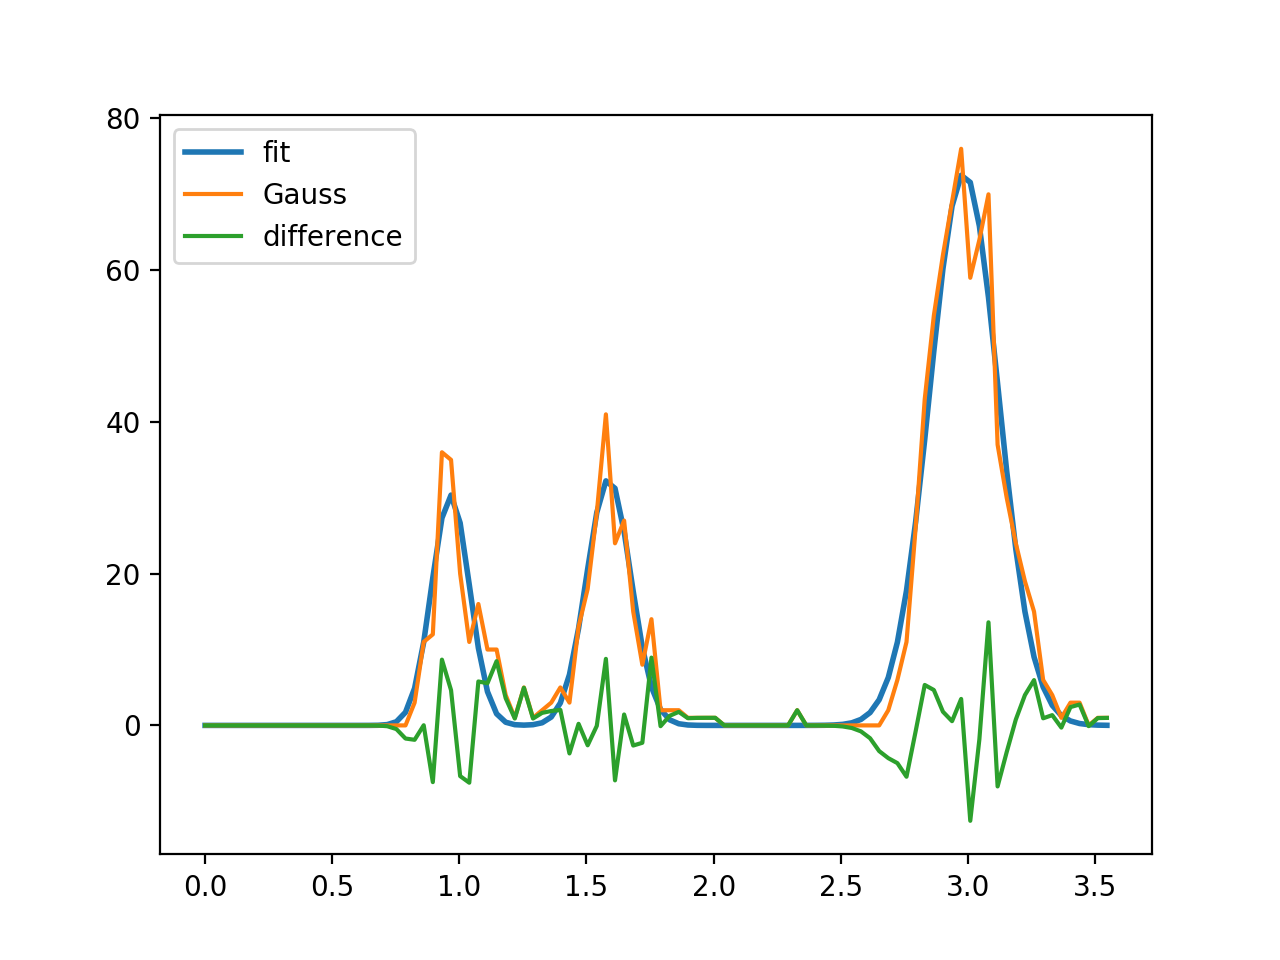

positions: 0.97, 1.59,2.98, 23.9,27.8
27 25.0


In [14]:
from scipy import signal
histo_frequency[0] = 0.
peakind = signal.find_peaks_cwt(histo_frequency, widths= np.arange(5,20))
for i in range(len(peakind)):
    plt.plot([histo_intensities[peakind[i]],histo_intensities[peakind[i]]],[0,histo_frequency[peakind[i]]])
guess = []
for i in range(len(peakind)):
    guess.extend([histo_intensities[peakind[i]],1,.1])
def gauss(x, p): # p[0]==mean, p[1]= area p[2]==fwhm, 
    return p[1] * np.exp(-(x- p[0])**2/(2.0*( p[2]/2.3548)**2))

def model3(x,p):
    y = np.zeros(len(x))
    number_of_peaks = int(len(p)/3)
    for i in range(number_of_peaks):
        y  = y + gauss(x, p[i*3:])
    return y

def residuals3(p, x, y  ):
    err = (y-model3(x,p))#/np.sqrt(np.abs(y))
    return err 
pin = np.array(guess)
p, cov = leastsq(residuals3, guess,  args = (histo_intensities[:-1],histo_frequency) )
#print(p)    
print(f'peak positions: {p[0]:.2f}, {p[3]:.2f}, {p[6]:.2f}')
print(f'chalcagenite site average Z: {np.sqrt(74**2/(p[6]/p[0])**2):.2f}, {np.sqrt(74**2/(p[6]/p[3])**2):.2f}')
    
plt.figure()
plt.plot(histo_intensities[:-1],model3(histo_intensities[:-1],p),label='fit',linewidth = 2)
plt.plot(histo_intensities[:-1],histo_frequency,label='Gauss')
plt.plot(histo_intensities[:-1],histo_frequency-model3(histo_intensities[:-1],p),label='difference')
plt.legend();
print(f'positions: {p[0]:.2f}, {p[3]:.2f},{p[6]:.2f}, {np.sqrt(74**2/(p[6]/p[0])**2):.1f},{np.sqrt(74**2/(p[6]/p[3])**2./2):.1f}')

print(27, (16+34)/2)

C:\Users\gduscher\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


<IPython.core.display.Javascript object>


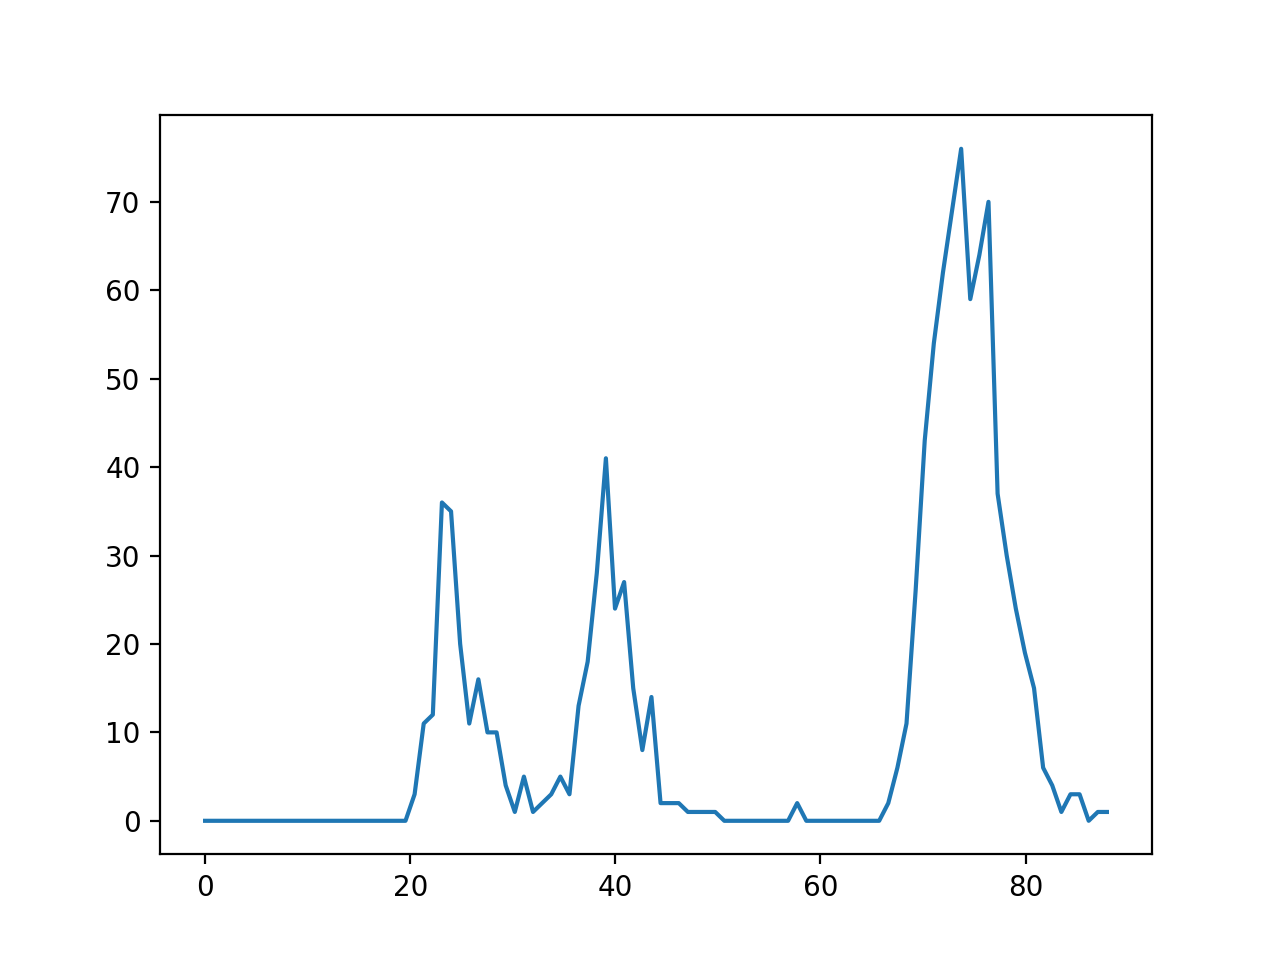

In [40]:
exponent = 3
Z = np.power(74**exponent/(p[6]/histo_intensities[:-1])**exponent, 1/exponent)

plt.figure()
plt.plot(Z,histo_frequency,label='Gauss')

392423


<IPython.core.display.Javascript object>


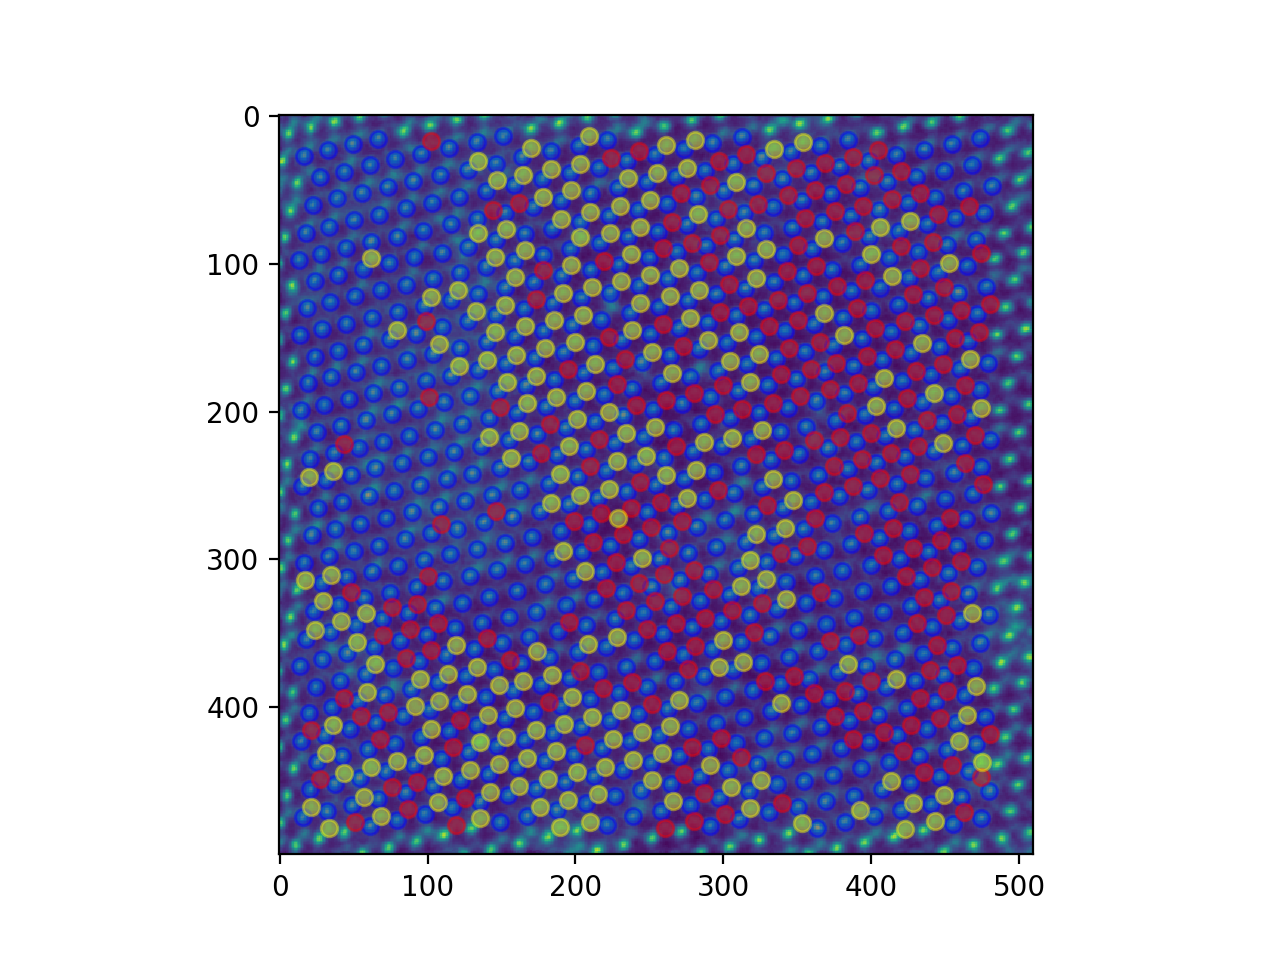

In [15]:
dark = np.where(np.array(out_tags2['Gauss_amplitude'])<1.3)
bright = np.where(np.array(out_tags2['Gauss_amplitude'])>2.5)
medium = np.where(np.logical_and(np.array(out_tags2['Gauss_amplitude'])<2.5, np.array(out_tags2['Gauss_amplitude'])>1.3))
print(np.sum(bright))
plt.figure()
plt.imshow(data, origin='upper')
plt.scatter(np.array(out_tags2['atoms'])[bright,0],np.array(out_tags2['atoms'])[bright,1],color='blue',alpha=0.4);
plt.scatter(np.array(out_tags2['atoms'])[dark,0],np.array(out_tags2['atoms'])[dark,1],color='red',alpha=0.4);
plt.scatter(np.array(out_tags2['atoms'])[medium,0],np.array(out_tags2['atoms'])[medium,1],color='yellow',alpha=0.4);


In [19]:
help(it.atomRefine)
out_tags['radius'] = int(5)# out_tags['atoms']['source_size']
out_tags['MaxInt'] = 0
out_tags['MinInt'] = 0
#print(out_tags['atoms']['mid_atoms'])
a = it.atomRefine(out_tags['reduced_image'], np.array(out_tags['mid_atoms'],dtype=int), out_tags)



Help on function atomRefine in module pyTEMlib.image_tools:

atomRefine(image, atoms, tags, maxDist=2)



C:\Users\gdusc\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


# Log Atom Refinement

In [17]:

out_tags2['analysis']= 'Atom Position Refinement'
out_tags2['notebook']= __notebook__ 
out_tags2['notebook_version']= __notebook_version__

name = 'Atom refinement'

log_group = ft.h5_add_Log(current_channel, name)

ft.h5_add_Data2Log(log_group, out_tags2)

usid.hdf_utils.print_tree(h5_file)




/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ Rigid_registration_drift
      ├ Rigid_registration_stack
      ├ _rigid_registration
      ├ analysis
      ├ data
      ├ extent
      ├ notebook
      ├ notebook_version
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ time_stamp
      ├ title
    ├ Log_001
      -------
      ├ Non_Rigid_registration_stack
      ├ _non-rigid_registration
      ├ analysis
      ├ data
      ├ extent
      ├ notebook
      ├ notebook_version
      ├ spatial_origin_x
      ├ spatial_origin_y
      ├ spatial_scale_x
      ├ spatial_scale_y
      ├ spatial_size_x
      ├ spatial_size_y
      ├ spatial_units
      ├ time_stamp
      ├ title
    ├ Log_002
      -------
      ├ _Atom finding
      ├ analysis
      ├ atoms
      ├ data
      ├ extent
      ├ image
      ├ log_chan

In [41]:
h5_file.close()